In [50]:
%matplotlib inline 
import numpy as np
import pandas as pd

import statsmodels.api as sm
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

In [51]:
df = pd.read_csv('data/listing_cleansed.csv')

### Filter on listings with high reviews number

In [52]:
df = df[~df.last_review.isnull()]
df = df[~df.review_scores_value.isnull()]
df = df[df.number_of_reviews>10]
#df = df[df.host_listings_count>1]

### Fill the missing data

In [53]:
columns_fill_na_with_mean = [u'bathrooms', u'bedrooms', u'beds', u'host_since',
       u'host_listings_count','host_response_time','host_response_rate']

df[columns_fill_na_with_mean]= df[columns_fill_na_with_mean].fillna(df[columns_fill_na_with_mean].mean())

In [54]:
df_missing_data = pd.DataFrame(df.isnull().sum()/len(df)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
df_missing_data[df_missing_data.missing_percent>0]

,missing_percent


### R-like str function

In [55]:
def get_unique(x):    
    return type(x.values[1]),x.unique()

def rstr(df):
    return df.apply(get_unique)

## Correlation with target

In [56]:
TARGET = 'availability_90'

In [57]:
df_corr = df.corr()[TARGET]
df_corr = pd.DataFrame(df_corr)
df_corr['corr_abs'] = np.abs(df_corr[TARGET])
df_corr = df_corr.sort_values(by='corr_abs',ascending=False)
df_corr.head(30)

,availability_90,corr_abs
availability_90,1.000000,1.000000
availability_60,0.952444,0.952444
availability_90_previous_month,0.834581,0.834581
availability_30,0.817201,0.817201
availability_60_previous_month,0.773977,0.773977
availability_30_previous_month,0.674569,0.674569
availability_365,0.554259,0.554259
availability_365_previous_month,0.535643,0.535643
last_review,-0.221465,0.221465
review_scores_value,-0.214581,0.214581


In [58]:
top_ten_corr = df_corr.head(5).index.values
print top_ten_corr

['availability_90' 'availability_60' 'availability_90_previous_month'
 'availability_30' 'availability_60_previous_month']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc87b9bce10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc87b60ef50>]], dtype=object)

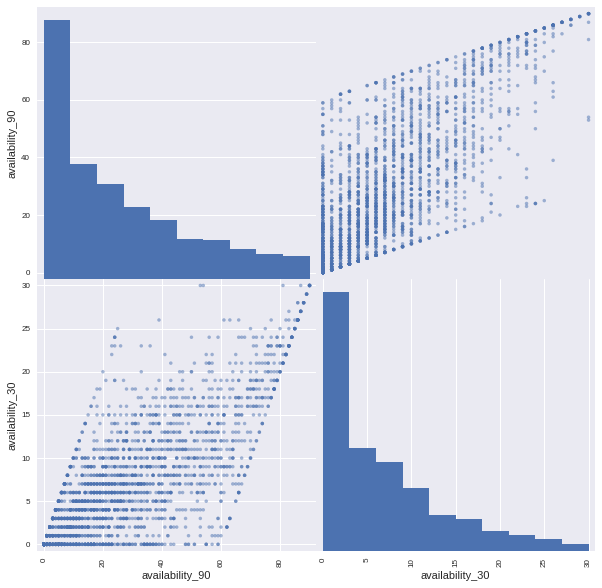

In [59]:
pd.plotting.scatter_matrix(df[[TARGET,'availability_30']], figsize=(10, 10))        

## Linear Model and R-squared

In [60]:
y = df.availability_90
X_columns = df_corr.index.values
X_columns = list(set(X_columns)-set(['availability_90','availability_30','availability_60','availability_365']))

In [61]:
X = df[X_columns]

In [62]:
X.shape

(2975, 200)

In [63]:
y.shape

(2975,)

In [64]:
mod =sm.OLS(y,sm.add_constant(X))

In [65]:
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        availability_90   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     43.27
Date:                Fri, 14 Jul 2017   Prob (F-statistic):               0.00
Time:                        14:45:02   Log-Likelihood:                -11737.
No. Observations:                2975   AIC:                         2.383e+04
Df Residuals:                    2798   BIC:                         2.489e+04
Df Model:                         176                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                 -1501.8093    730.829     -2.055      0.040   -2934.828     -68.791
amenities__Firmmatress                                   10.9439     18.851      0.581      0.562     -26.019      47.907
reviews_per_month                                        -0.0235      0.335     -0.070      0.944      -0.680       0.633
neighbourhood_group_cleansed__Neuklln                  -126.3494     60.437     -2.091      0.037    -244.854      -7.844
property_type__Guesthouse                             -8.598e-06   4.16e-06     -2.068      0.039   -1.67e-05   -4.46e-07
amenities__Dishesandsilverware                          -17.5396     56.344     -0.311      0.756    -128.020      92.941
amenities__WasherDryer                                    4.3086      5.924      0.727      0.467      -7.307      15.925
neighbourhood_group_cleansed__Mitte                    -127.7080     61.328     -2.082      0.037    -247.960      -7.456
require_guest_profile_picture                             3.5064      2.215      1.583      0.114      -0.837       7.850
amenities__Internet                                      -0.3406      0.687     -0.496      0.620      -1.687       1.006
review_scores_cleanliness                                 0.4343      0.495      0.878      0.380      -0.535       1.404
amenities__Stairgates                                     2.2944      8.570      0.268      0.789     -14.509      19.098
amenities__Accessibleheightbed                            7.1945     27.787      0.259      0.796     -47.291      61.679
neighbourhood_group_cleansed__Lichtenberg              -125.8900     61.289     -2.054      0.040    -246.067      -5.713
neighbourhood_group_cleansed__FriedrichshainKreuzberg  -125.4765     60.934     -2.059      0.040    -244.956      -5.997
amenities__Petsallowed                                    1.2021      0.730      1.647      0.100      -0.229       2.633
host_since                                                0.0008      0.001      1.311      0.190      -0.000       0.002
bed_type_RealBed                                       -301.7362    146.269     -2.063      0.039    -588.542     -14.931
amenities__Accessibleheighttoilet                      1.326e-09   6.45e-10      2.056      0.040    6.11e-11    2.59e-09
neighbourhood_group_cleansed__Reinickendorf            -128.7086     62.452     -2.061      0.039    -251.165      -6.252
latitude                                                 37.8640     18.772      2.017      0.044       1.055      74.673
review_scores_checkin                                    -0.2793      0.674     -0.415      0.679      -1.600       1.042
host_verification_manual_online  

In [66]:
y.shape

(2975,)

### Train test split

In [67]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2)

### Linear Regression

In [68]:
lm = LinearRegression()
lm.fit(X_train,y_train)
prediction = lm.predict(X_test)
r2_score(y_test.values,prediction)

-17423212.46980413

In [69]:
df_prediction = pd.DataFrame({'observed':y_test,'predicted':prediction})

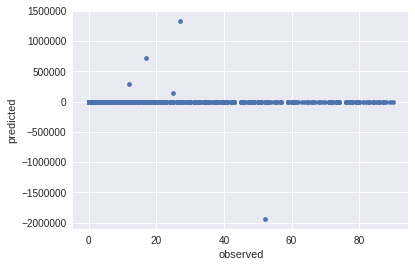

In [70]:
df_prediction.plot.scatter(x='observed',y='predicted')

### Random Forest

In [71]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
prediction = rf.predict(X_test)
r2_score(y_test.values,prediction)

0.66797898345132656

### XGB

In [72]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)
prediction = xgb.predict(X_test)
r2_score(y_test.values,prediction)

0.69315787101910897